# Accuracy

In this notebook we will look at the impact on accuracy of a model when we use imbalanced data. We will compare different algorithms and how they behave on different datasets
***

In [2]:
## Imports ##

import numpy as np

# matplotlib
import matplotlib as mlp
import matplotlib.pyplot as plt

# sklearn
from sklearn.linear_model import LogisticRegression
from sklearn.datasets import make_classification

# skactiveml
from skactiveml.classifier import SklearnClassifier
from skactiveml.pool import UncertaintySampling
from skactiveml.pool import QueryByCommittee
from skactiveml.pool import RandomSampling
from skactiveml.utils import unlabeled_indices, labeled_indices, MISSING_LABEL
from skactiveml.visualization import plot_decision_boundary, plot_utilities

# set warnings
import warnings
mlp.rcParams["figure.facecolor"] = "white"
warnings.filterwarnings("ignore")

[We already know](https://dsgissin.github.io/DiscriminativeActiveLearning/) that active learning algorithms can drastically reduce the amount of samples needed to be labeled in order to obtain good accuracy. We will now look at the accuracy when we use imbalanced data.

In [3]:
def get_data(weights=None, random_state=0):
    X, y = make_classification(n_samples=100, n_features=2, n_redundant=0, random_state=random_state)
    Xi, yi = make_classification(n_samples=100, n_features=2, n_redundant=0, weights=weights, random_state=random_state)
    return (X, y, Xi, yi)

In [4]:
def get_accuracy(qs_type, weights=None, cycles=30, **kwargs):
    data = []
    for rand in range(100):
        qs = qs_type(random_state=rand, **kwargs)
        X, y_true = make_classification(n_samples=100, n_features=2, n_redundant=0, weights=weights, random_state=rand)
        y = np.full(shape=y_true.shape, fill_value=MISSING_LABEL)
        out = []
        clf = SklearnClassifier(LogisticRegression(), classes=np.unique(y_true))

        clf.fit(X, y)
        for _ in range(cycles):
            i = qs.query(X, y) if type(qs) == RandomSampling else qs.query(X, y, clf)
            y[i] = y_true[i]
            clf.fit(X,y)
            out.append(clf.score(X,y_true))
        data.append(out)

    return np.mean(np.array(data), axis=0)

def get_accuracy_imbalanced(qs_type, weights=None, cycles=30, **kwargs):
    data = []
    for rand in range(100):
        qs = qs_type(random_state=rand, **kwargs)
        X, y_true, Xi, yi_true = get_data(weights=weights, random_state=rand)
        yi = np.full(shape=yi_true.shape, fill_value=MISSING_LABEL)
        out = []
        clf = SklearnClassifier(LogisticRegression(), classes=np.unique(y_true))

        clf.fit(Xi, yi)
        for _ in range(cycles):
            i = qs.query(Xi, yi) if type(qs) == RandomSampling else qs.query(Xi, yi, clf)
            yi[i] = yi_true[i]
            clf.fit(Xi,yi)
            out.append(clf.score(X,y_true))
        data.append(out)

    return np.mean(np.array(data), axis=0)

In [5]:
def plot_accuracy(title, nrml, imbalanced, ax):
    c = np.arange(len(nrml))
    ax.plot(c, nrml, label='Balanced data')
    ax.plot(c, imbalanced, label='Imbalanced data')

    ax.set_ylabel('Accuracy')
    ax.set_xlabel('Samples asked at oracle')
    ax.set_title(title)
    ax.legend()


In [6]:
acc_nrml_random = get_accuracy(RandomSampling)
acc_imbalanced_random = get_accuracy_imbalanced(RandomSampling, weights=[0.8, 0.2])

In [7]:
acc_nrml_uncertainty = get_accuracy(UncertaintySampling, method='least_confident')
acc_imbalanced_uncertainty = get_accuracy_imbalanced(UncertaintySampling, weights=[0.8, 0.2], method='least_confident')

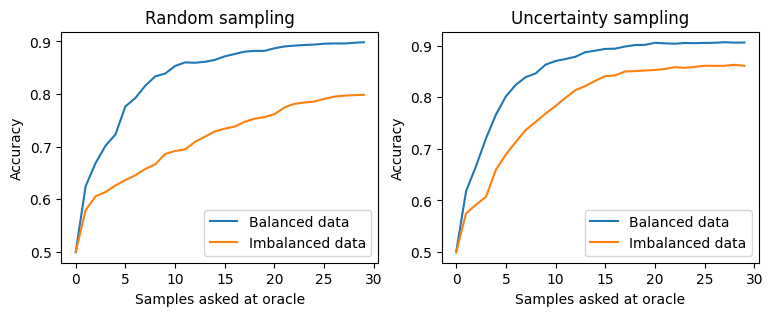

In [9]:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(9, 3))

plot_accuracy('Random sampling', acc_nrml_random, acc_imbalanced_random, axs[0])
plot_accuracy('Uncertainty sampling', acc_nrml_uncertainty, acc_imbalanced_uncertainty, axs[1])

fig.show()